In [1]:
%matplotlib inline

In [6]:
# Old version that uses smooth functions

# nonstandard libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

class DrugSimulator:
    def __init__(self, goals, k_slopes, v_slopes, known_params, unknown_params, dosage_period, duration, measurement_times):
        # set peak and trough goals
        self.y_peak, self.y_trough = goals

        # samples of unknown parameters
        self.k_slopes = k_slopes
        self.v_slopes = v_slopes

        # unpack the known paramaters for the patient
        self.k_int, self.cl_cr, self.bw = known_params
        self.k_slope, self.v_slope = unknown_params

        # actual patient parameters
        self.k_el = self.k_int + self.cl_cr * self.k_slope
        self.v_d = self.v_slope * self.bw

        # how often dosage is administered
        self.dosage_period = dosage_period
        # how long the treatment lasts in hours
        self.duration = duration
        # the times at which blood samples will be taken
        self.measurement_times = measurement_times
        # the times that the doses will be administered
        self.dose_times = list(filter(lambda t: t % self.dosage_period == 0, range(duration)))
        # where taken measurements will be stored
        self.measurements = []

        # initialize dosage and prior matrix
        self.prior = self.initialize_prior()
        self.current_dosage = self.initialize_dosage(0, 11)

        # set initial condition
        self.init = 0

    def initialize_prior(self):
        ''' Initializes our Bayesian prior '''

        # create a matrix of zeroes
        prior = [ [ 0 for i in range(len(self.v_slopes)) ] for j in range(len(self.k_slopes)) ]
        # initially set each model to have the same weight
        # TODO: initialize each model to have a distinct weight
        w = 1/(len(self.k_slopes) * len(self.v_slopes))
        
        for i in range(len(prior)):
            for j in range(len(prior[0])):
                # set each element of the matrix to triples
                # each containing the weight, the elimination rate
                # and the volume of distribution
                prior[i][j] = (w, self.k_slopes[i]*self.cl_cr+self.k_int, self.v_slopes[j]*self.bw)

        return prior

    def initialize_dosage(self, tp, tt):
        ''' Calculates the optimal initial dosage '''

        dose = 0

        for i in range(len(self.prior)):
            for j in range(len(self.prior[0])):
                # unpack the values of the triple
                w, k, v = self.prior[i][j]

                # add the weighted dose to the total sum
                dose += self.optimal_dose(tp, tt, k, v, 0) * w

        return dose

    def optimal_dose(self, tp, tt, k, v, init):
        ''' Calculates the optimal dosage for a set of parameters '''

        alpha = lambda t: init*np.exp(-k*t)/v
        beta = lambda t: sum([ heaviside(t-dose_time)*np.exp(-k*(t-dose_time)) for dose_time in self.dose_times ])/v
        numer = beta(tp)*(self.y_peak-alpha(tp))+beta(tt)*(self.y_trough-alpha(tt))
        denom = beta(tp)**2 + beta(tt)**2
        return numer / denom

    def solution(self, t, k, v, init=None):
        ''' Yields concentration at time t given parameters k and v '''

        total = init if init else self.init

        for dose_time in self.dose_times:
            total += self.current_dosage * heaviside(t - dose_time) * np.exp(k * dose_time)

            if t < dose_time:
                break

        return np.exp(-k * t) * total / v

    def update_prior(self, t):
        total = 0
        
        for i, row in enumerate(self.prior):
            for j, elem in enumerate(row):
                w, k, v = elem

                patient_peak = self.solution(t, self.k_el, self.v_d)
                parameter_peak = self.solution(t, k, v)

                peak_observation = patient_peak + np.random.normal(0, 0.3)

                patient_trough = self.solution(t + self.dosage_period - 1, self.k_el, self.v_d)
                parameter_trough = self.solution(t + self.dosage_period - 1, k, v)

                trough_observation = patient_trough + np.random.normal(0, 0.3)

                w *= st.norm.pdf(peak_observation, parameter_peak, 0.3)
                w *= st.norm.pdf(trough_observation, parameter_trough, 0.3)

                self.prior[i][j] = (w, k, v)
                total += w

        for i in range(len(self.prior)):
            for j in range(len(self.prior[0])):
                w, k, v = self.prior[i][j]
                self.prior[i][j] = (w/total, k, v)

    def simulate(self, k, v, step):
        self.init = 0
        self.measurements = []
        timesteps = [ i*step for i in range(int(self.duration/step)) ]
        #time_perturbations = [ np.random.normal() for ]
        steps = [[0]]
        vals = [[0]]

        for step in timesteps:
            #val = self.solution(step, k, v, self.init)

            if step in self.measurement_times:
                self.update_prior(step)
                self.current_dosage = self.initialize_dosage(step, step+11)
                #self.current_dosage = self.initialize_dosage(step-12, step-1)
                self.measurements = self.measurements + []
                
                try:
                    steps.append([steps[-1][-1]])
                    vals.append([vals[-1][-1]])
                    self.init = vals[-1][-1]
                    print('Setting initial condition to {}.'.format(vals[-1][-1]))
                    
                except Exception as e:
                    print(e)
                    
                print('Changed dosage at time {}.'.format(step))
                print(self.current_dosage)

            steps[-1].append(step)
            #vals[-1].append(val)
            vals[-1].append(self.solution(step, k, v, self.init))

        return steps, vals

    def graph(self, k, v, step):
        self.prior = self.initialize_prior()
        self.current_dosage = self.initialize_dosage(0, 11)
        ts, ys = self.simulate(k, v, step)
        time = []
        for i in range(len(ts)):
            plt.plot(ts[i], ys[i], 'C0' if i%2==0 else 'C1')
            time = time + ts[i]

        peak = [ self.y_peak for t in time ]
        trough = [ self.y_trough for t in time ]
        plt.plot(time, peak, 'C3')
        plt.plot(time, trough, 'C3')
        plt.xlabel('Time (Hours)')
        plt.ylabel('Drug Concentration (mg/L)')
        plt.show()
        

def heaviside(t):
    return 1 if t >= 0 else 0

def sample_k_slopes(num, p, mean1, stdev1, mean2, stdev2):
    return np.random.normal(mean1, stdev1, num) if np.random.uniform() >= p else np.random.normal(mean2, stdev2, num)

def sample_v_slopes(num, mean, stdev):
    return np.random.normal(mean, stdev, num)


0.0041666666666666675 0.0020833333333333333
Setting initial condition to 0.9657562298485141.
Changed dosage at time 12.0.
126.025972472
Setting initial condition to 1.026998407399212.
Changed dosage at time 84.0.
120.136425359
Setting initial condition to 0.9790046937946298.
Changed dosage at time 156.0.
122.933571361


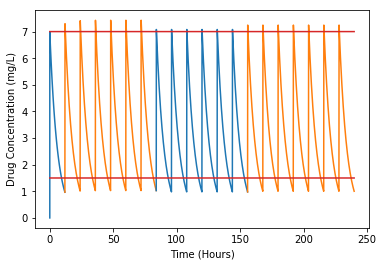

In [15]:
#np.random.seed(0)

# meh
magic = 0.00625
mean1 = magic-magic/3
mean2 = magic/3

print(mean1, mean2)
k_int = 0.01
k_slope = (mean1 + mean2) / 2
cl_cr = 50

k = k_int + cl_cr * k_slope

v_slope = 0.2806
bw = 70
v = v_slope * bw

# Start here
goals = (7, 1.5)
k_slopes = sample_k_slopes(9, 0.2, mean1, 0.001, mean2, 0.001)
v_slopes = sample_v_slopes(9, 0.2806, 0.05)
known_params = (k_int, cl_cr, bw)
unknown_params = ((mean1+mean2)/2, v_slope)
dosage_period = 12
duration = 240
measurement_times = [12, 84, 156]

ds = DrugSimulator(goals, k_slopes, v_slopes, known_params, unknown_params, dosage_period, duration, measurement_times)
ds.graph(k, v, step=0.1)